In [1]:
from __future__ import print_function, division
import os
import numpy as np
import cv2
import glob
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torch.utils.data import Dataset, DataLoader , random_split
from torchvision import utils, transforms
import torch.optim as optim

In [2]:
import import_ipynb
from Deepfake_Dataloader import DeepfakeFaceDataset, ToTensor, InceptionResnetV1

In [6]:
num_trainset = 23
csv_path = 'metadata_sample3.csv'
file_path = 'sample3/'

transformed_dataset = DeepfakeFaceDataset(csv_file=csv_path,
                                        root_dir=file_path,
                                        transform=transforms.Compose([
                                                ToTensor()
                                           ]))
train_set, val_set = random_split(transformed_dataset, [num_trainset, len(transformed_dataset)-num_trainset])
print('train',num_trainset)
print('val',len(transformed_dataset)-num_trainset)
trn_loader = DataLoader(train_set, batch_size=1,
                        shuffle=True)
val_loader = DataLoader(val_set, batch_size=1,
                        shuffle=True)

train 23
val 2


0 torch.Size([1, 10, 3, 256, 256]) torch.Size([1, 1])
1 torch.Size([1, 11, 3, 256, 256]) torch.Size([1, 1])
2 torch.Size([1, 3, 3, 256, 256]) torch.Size([1, 1])
3 torch.Size([1, 2, 3, 256, 256]) torch.Size([1, 1])


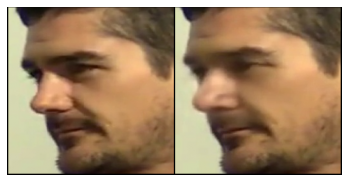

In [8]:
def show_label_batch(sample_batched):
    """ 샘플들의 배치에서 이미지와 함께 랜드마크를 보여줍니다. """
    images_batch, label_batch = \
            (sample_batched['image']/255).squeeze(0), sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid = utils.make_grid(images_batch)

    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    
for i_batch, sample_batched in enumerate(trn_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())

    # 4번째 배치를 보여주고 반복문을 멈춥니다.
    if i_batch >= 3:
        plt.figure()
        show_label_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [5]:
def Hinge_embedding_loss(input, target,label):
    margin = 1.0
    loss = torch.nn.L1Loss(reduction='mean')
    if label == 1:
        return loss(input,target)
    else:
        return max(torch.zeros(1, requires_grad=True),margin-loss(input,target))

In [6]:
def Hinge_embedding_loss_val(input, target,label):
    margin = 1.0
    loss = torch.nn.L1Loss(reduction='mean')
    if label == 1:
        return loss(input,target)
    else:
        return max(torch.tensor(0.0),margin-loss(input,target))

In [8]:
size = (256, 256)
Embedding_Model = InceptionResnetV1().double()

# criterion = Hinge_embedding_loss()
optimizer = optim.Adam(Embedding_Model.parameters(), lr=0.005)

In [9]:
Embedding_Model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [10]:
def cosine_sim(v):
    v = torch.DoubleTensor(v)
    n = len(v)
    sim = torch.zeros(n,n,requires_grad=False)
    
    cos = nn.CosineSimilarity(dim=0,eps=1e-6)
    for i in range(n):
        for j in range(i,n):
            sim[i][j],sim[j][i] = cos(v[i],v[j]),cos(v[j],v[i])

    return sim

In [ ]:
num_epochs = 1
num_batches = len(trn_loader)
use_cuda = False

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(trn_loader):
        x = torch.DoubleTensor(data['image']/255)
        print(x.shape)
        label = data['label']
        if use_cuda:
            x = torch.cuda.DoubleTensor(x.cuda())
            label = label.cuda()
        
        # grad init
        optimizer.zero_grad()
        
        # forward propagation
        face_embedding = Embedding_Model(x.squeeze(0))
        cosine_matrix = cosine_sim(face_embedding)
        embedoutput=cosine_matrix
        embedtarget = torch.Tensor(np.identity(len(face_embedding)))

        #calcualte loss
        loss = Hinge_embedding_loss(embedoutput, embedtarget,label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del embedoutput
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x = torch.DoubleTensor(val['image']/255)
                    val_label = val['label']
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    
                    # forward propagation
                    
                    face_embedding_val = Embedding_Model(val_x.squeeze(0))
                    cosine_matrix_val = cosine_sim(face_embedding_val)
                    embedoutput_val= cosine_matrix_val
                    embedtarget_val = torch.Tensor(np.identity(len(face_embedding_val)))

                    #calcualte loss
                    v_loss = Hinge_embedding_loss_val(embedoutput_val, embedtarget_val, val_label)
                    val_loss += v_loss
                    
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.8f} | val loss: {:.8f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader)
            ))
            torch.save(Embedding_Model.state_dict(),'model_save.pt')
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            trn_loss = 0.0

torch.Size([1, 8, 3, 256, 256])
